<a href="https://colab.research.google.com/github/LaurentTits/AI_execices/blob/main/2022_10_27_Defi1_db2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Thu Oct 27 18:42:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from PIL import Image
from google.colab import files, drive
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**3. Téléchargement des données d'entrainement "DB2"**

In [4]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [6]:
!rm -rf sample_data
! wget --no-check-certificate https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_2.tar
! tar xf FIRE_DATABASE_2.tar -C 'bases' --one-top-level
! rm FIRE_DATABASE_2.tar

--2022-10-27 18:45:54--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_2.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163223040 (1.1G) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_2.tar.1’

FIRE_DATABASE_2.tar 100%[===================>]   1.08G  11.7MB/s    in 85s     

2022-10-27 18:47:21 (13.0 MB/s) - ‘FIRE_DATABASE_2.tar.1’ saved [1163223040/1163223040]



#**4. Téléchargement des données de test "Test Dataset"**

In [7]:
!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
! tar xf test.tar -C 'bases' --one-top-level
! rm test.tar

--2022-10-27 18:47:34--  http://195.154.53.219/downloads/test.tar
Connecting to 195.154.53.219:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58196480 (56M) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]  55.50M  13.6MB/s    in 5.2s    

2022-10-27 18:47:39 (10.6 MB/s) - ‘test.tar’ saved [58196480/58196480]



#**5. Création du fichier de labels "classes.txt"**

In [8]:
# !printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> /content/gdrive/MyDrive/classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [22]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=5 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}  
dataset_name='FIRE_DATABASE_2' #@param ["small","FIRE_DATABASE_2","DB2","DB3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "/content/gdrive/MyDrive/classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [10]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
	batch_size=batch_size,   # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="validation",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
	batch_size=batch_size,   # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [14]:
base_model = Xception(include_top=False, weights='imagenet', input_shape = (input_dim, input_dim, 3))
#create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)


83683744/83683744 [==============================] - 1s 0us/step


In [24]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
base_model.trainable = False
print(model.summary())
base_model.trainable = True

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [17]:
# recompiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# **12. Entraîner le modèle**

In [25]:
for layer in base_model.layers:
  layer.trainable = False
#base_model.trainable = False

stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, 
                        verbose=1, mode='auto')
#ckpt_save = os.path.join(".",'model_fine_ep{epoch}_valloss{val_loss:.3f}.h5')
ckpt_save = os.path.join("/content/gdrive/MyDrive",'model_db2_ep{epoch}_valloss{val_loss:.3f}.h5')

checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

callback_list = [checkpoint, stopper]

history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
                    epochs=epochs, callbacks=callback_list)




Epoch 1/5


ResourceExhaustedError: ignored

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
# checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

#model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    monitor='val_accuracy',
#    mode='max',
#    save_best_only=True)

#history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
#                    epochs=epochs, callbacks=[model_checkpoint_callback])

model.save('models/db1model')


In [ ]:
saved_model = keras.models.load_model('models/firstmodel')


In [ ]:
db1_model = keras.models.load_model('/content/gdrive/MyDrive/model_db1_ep4_valloss0.074.h5')

#**14. Afficher des courbes d'entrainement/validation**

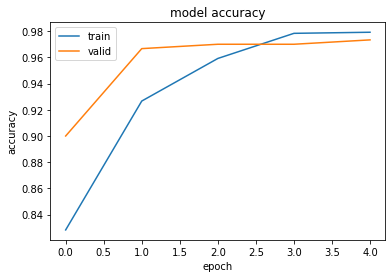

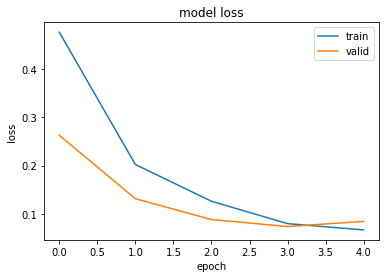

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.show()

# **15. Créer le jeu de données de test**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	test_dataset,               # chemin vers le jeu de données
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
  batch_size=batch_size,   # not useful for test_ds
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 210 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test**

In [ ]:
score = model.evaluate(test_ds)
print('score', score[0], score[1])

27/27 [==============================] - 3s 96ms/step - loss: 1.0615 - accuracy: 0.7286
score 1.061485767364502 0.7285714149475098


In [ ]:
score = db1_model.evaluate(test_ds)
print('score', score[0], score[1])

27/27 [==============================] - 4s 86ms/step - loss: 0.8751 - accuracy: 0.7381
score 0.8751474022865295 0.738095223903656


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

1/1 [==============================] - 1s 685ms/step
Class Name : fire --- Class Probability: 92.66%
Class Name : no_fire --- Class Probability: 1.74%
Class Name : start_fire --- Class Probability: 5.60%


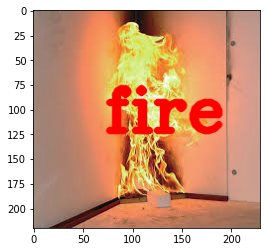

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 0s 34ms/step
Class Name : fire --- Class Probability: 0.50%
Class Name : no_fire --- Class Probability: 89.37%
Class Name : start_fire --- Class Probability: 10.13%


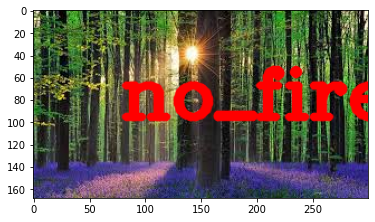

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 0s 21ms/step
Class Name : fire --- Class Probability: 13.16%
Class Name : no_fire --- Class Probability: 1.53%
Class Name : start_fire --- Class Probability: 85.31%


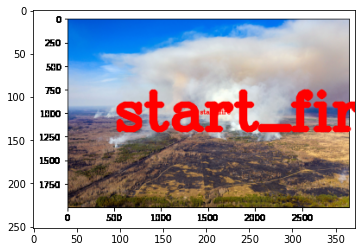

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "start_fire.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 1s 661ms/step
Class Name : fire --- Class Probability: 50.07%
Class Name : no_fire --- Class Probability: 22.35%
Class Name : start_fire --- Class Probability: 27.57%


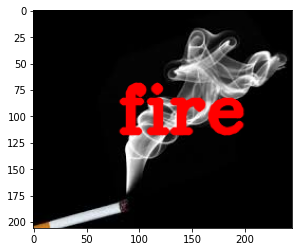

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "smoke_cigaret.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = first_model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from PIL import Image
from google.colab import files, drive
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
classes_path = "/content/gdrive/MyDrive/classes.txt"
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

In [ ]:
first_model = keras.models.load_model('/content/gdrive/MyDrive/model_fine_ep5_valloss0.222.h5')

In [ ]:
files.upload()

1/1 [==============================] - 9s 9s/step
Class Name : fire --- Class Probability: 92.45%
Class Name : no_fire --- Class Probability: 4.94%
Class Name : start_fire --- Class Probability: 2.61%


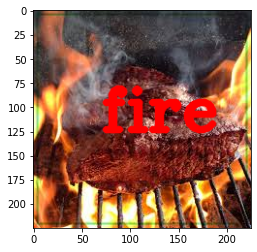

In [ ]:
%matplotlib inline

input_dim=299
image_path =  "bbq.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = first_model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()